In [12]:
import blocksci
import matplotlib.pyplot as plt
import matplotlib.ticker
import collections
import pandas as pd
import numpy as np
%matplotlib notebook

In [13]:
chain = blocksci.Blockchain('/home/shresthanikesh23/bitcoin-data')

In [14]:
%time net_coins_per_block = chain.map_blocks(lambda block: block.net_address_type_value())

CPU times: user 12.9 s, sys: 4.78 s, total: 17.7 s
Wall time: 5min 33s


In [15]:
df = pd.DataFrame(net_coins_per_block).fillna(0).cumsum()/1e8

In [16]:
df = chain.heights_to_dates(df)

In [17]:
df = df.rename(columns={t:str(t) for t in df.columns})

<IPython.core.display.Javascript object>


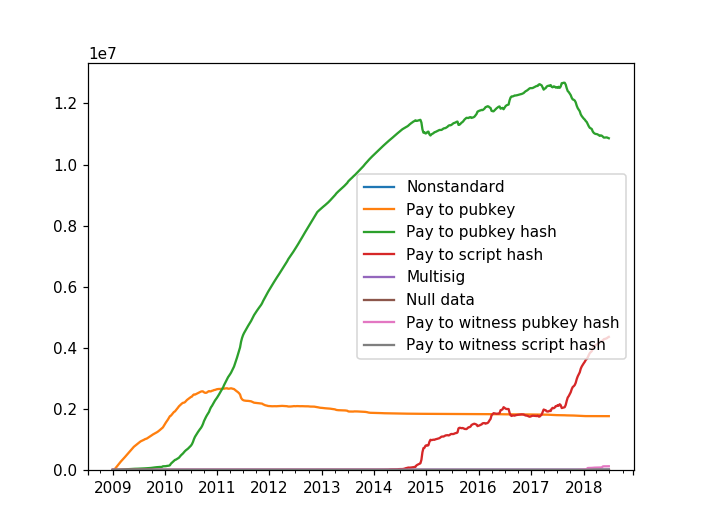

(0, 13313558.289755534)

In [18]:
ax = df.resample("W").mean().plot()
ax.set_ylim(ymin=0)

In [19]:
df = pd.DataFrame(chain[465100].txes.fee_per_byte(), columns=["Satoshi per byte"])

<IPython.core.display.Javascript object>


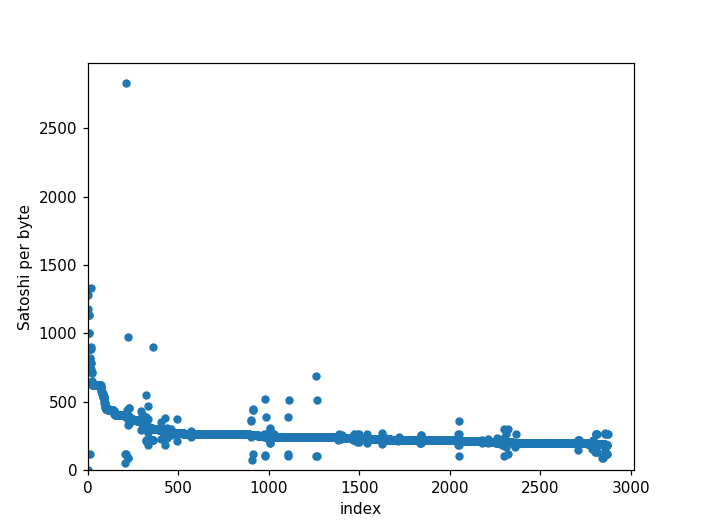

In [20]:
ax = df.reset_index().plot.scatter(x="index", y="Satoshi per byte")
ax.set_ylim(0)
ax.set_xlim(0)

plt.show()

In [21]:
%time txes = chain.blocks.txes.including_output_of_type(blocksci.address_type.nulldata).all

CPU times: user 30.7 s, sys: 11.8 s, total: 42.5 s
Wall time: 7min 2s


In [22]:
%time labels = [(tx.block.time, blocksci.label_application(tx)) for tx in txes]

CPU times: user 2min 26s, sys: 25.3 s, total: 2min 51s
Wall time: 17min 9s


In [23]:
df = pd.DataFrame(labels, columns=["date", "label"])
df = df.reset_index().groupby(["date", "label"]).count().unstack(level=-1).fillna(0)

In [24]:
df.columns = df.columns.droplevel()

In [25]:
important_columns = list(df[df.index > pd.to_datetime("1-1-2016")].sum().sort_values()[-10:].index)

In [26]:
important_columns = [x for x in important_columns if "Address" not in x]

<IPython.core.display.Javascript object>


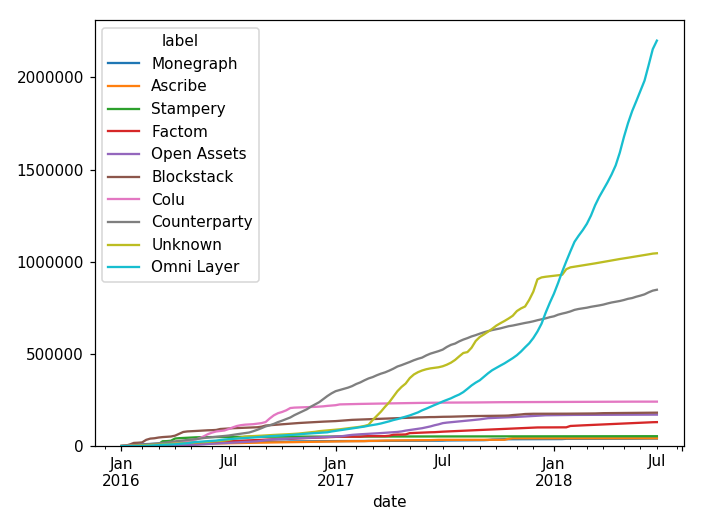

In [27]:
ax = df[df.index > pd.to_datetime("1-1-2016")].cumsum().resample("w").mean()[important_columns].plot()
ax.set_ylim(0)
plt.tight_layout()

In [28]:
converter = blocksci.CurrencyConverter()

In [29]:
blocks = chain.range('2017')

In [30]:
%time fees = blocks.fee / blocks.tx_count

CPU times: user 4.12 s, sys: 3.23 s, total: 7.36 s
Wall time: 2min 45s


In [31]:
times = blocks.time

In [32]:
fees

array([ 29781.58134083,  29929.08557284,  28104.0990753 , ...,
       131026.13026052,  59239.00443951, 148873.99825277])

In [33]:
df = pd.DataFrame({"Fee": fees}, index=times)

In [34]:
df = converter.satoshi_to_currency_df(df, chain)

<IPython.core.display.Javascript object>


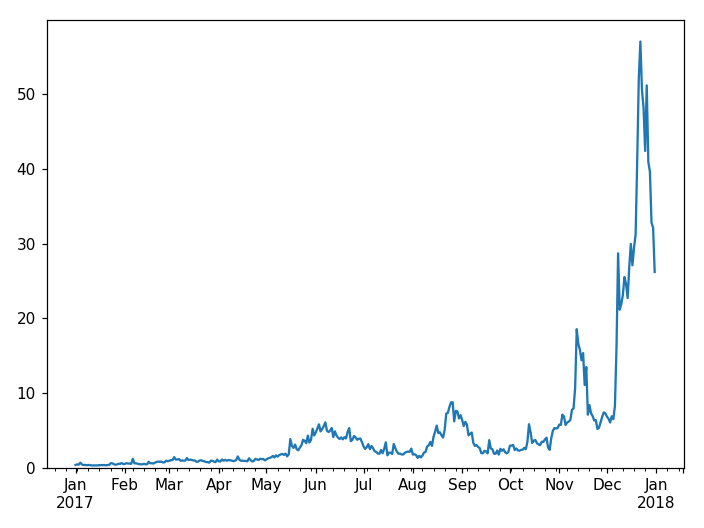

In [35]:
ax = df.resample("d").mean().plot(legend=False)
ax.set_ylim(ymin=0)
plt.tight_layout()

In [36]:
%time high_fee_txes = chain.cpp.filter_tx("fee(tx) > 10000000", 0, len(chain))




CPU times: user 1min 29s, sys: 16.5 s, total: 1min 45s
Wall time: 5min 8s


In [37]:
convertor = blocksci.CurrencyConverter()

In [38]:
df = pd.DataFrame([(tx.block.height, tx.fee) for tx in high_fee_txes], columns=["height", "fee"])

In [39]:
df.head()

,height,fee
0,2817,100000000
1,2817,100000000
2,19863,14000000
3,20770,13000000
4,23079,12000000


In [40]:
df.index = df["height"]

In [41]:
df['fee'] = df.apply(lambda x: converter.satoshi_to_currency(x['fee'], chain[x['height']].time), axis=1)

In [42]:
df.head()

,height,fee
height,,
2817,2817,0.0
2817,2817,0.0
19863,19863,0.0
20770,20770,0.0
23079,23079,0.0


In [43]:
df = df[df['fee'] > 1000]

In [44]:
df = chain.heights_to_dates(df)

<IPython.core.display.Javascript object>


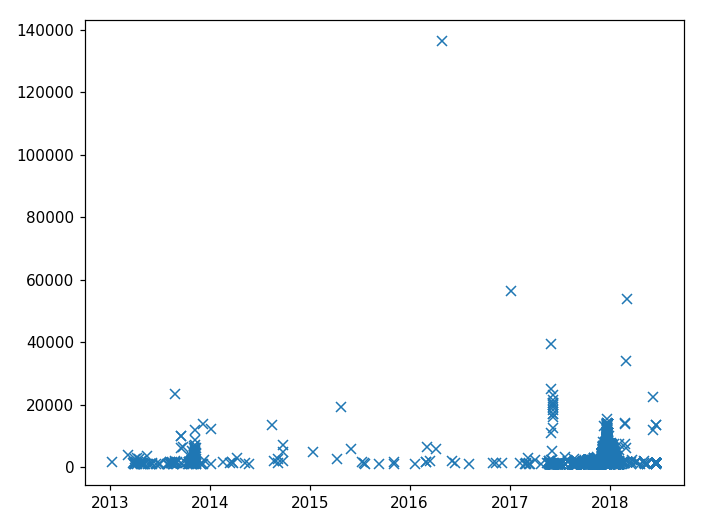

In [45]:
fig, ax = plt.subplots()
ax.plot_date(df.index, df['fee'], fmt="x")

formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter)
plt.tight_layout()

In [46]:
cm = blocksci.cluster.ClusterManager('/home/shresthanikesh23/cluster-data', chain)

In [47]:
address = chain.address_from_string("3D2oetdNuZUqQHPJmcMDDHYoqkyNVsFk9r")

In [48]:
cluster = cm.cluster_with_address(address)

In [49]:
%time sum(address.balance(494653) for address in cluster.addresses) / 1e8

CPU times: user 356 ms, sys: 658 ms, total: 1.01 s
Wall time: 1min 56s


168285.73928041